# Mexican_All

### Jian Jiao

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [277]:
data = pd.read_csv('R_Mexican_All.csv');

/var/folders/j5/r9sgfm5933v8c8tsrm_s6nn00000gn/T/ipykernel_900/3023449674.py:1: DtypeWarning: Columns (19,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('R_Mexican_All.csv');


In [194]:
# select students
dat = data.iloc[:,3:57]
stu = dat.loc[dat.freshmancode.str.isdigit()]

In [264]:
# count null values
nas = stu.apply(lambda x:x.isna().sum())
nas.loc[nas > 0]

race                  278
international         356
item_food_own2      28355
item_food_own3      46753
item_food_own4      50460
item_food_own5      51213
item_food_own6      51350
item_food_own7      51371
item_food_own8      51379
item_food_front1        2
item_food_front2    28258
item_food_front3    46578
item_food_front4    50388
item_food_front5    51183
item_food_front6    51335
item_food_front7    51367
item_food_front8    51380
item_type_own1          1
item_type_own2      28355
item_type_own3      46753
item_type_own4      50460
item_type_own5      51213
item_type_own6      51350
item_type_own7      51371
dtype: int64

In [295]:
def preprocessing(df):
    df = df.copy()
    # gender
    df['gender'] = df.gender.apply(lambda x: 'M' if x == 0 or x == 'M' else 'F')
    
    # MC Sampling Fillna (Col = [race, international])
    race_inte = df[['race','international']]
    bools = race_inte.isna().apply(lambda x:False if x.sum() == 0 else True, axis=1)
    samps = race_inte.dropna().sample(n=bools.sum(),random_state=1,replace=True)
    df.loc[bools, ['race','international']] = samps.to_numpy()
    
    # item_type_own Combination
    def combine_type(with_num, type_row, typ):
        res = ''
        cnts = type_row.value_counts()
        for t in typ:
            try:
                if cnts[t] > 0:
                    if not with_num:
                        res += '+' + t
            except:
                continue
        if with_num:
            return pd.Series([cnts[x] if x in cnts else 0 for x in typ])
        else:
            res = res[1:]
            return res
    
    typ = ['F','Sd','Sn','D']
    type_df = df.loc[:,'item_type_own1':'item_type_own7']
    df = df.assign(item_combinations = type_df.apply(lambda x:combine_type(False, x, typ), axis=1))
    df = pd.concat([df,type_df.apply(lambda x:combine_type(True, x, typ), axis=1).rename(dict(zip(range(len(typ)),typ)),axis=1)],axis=1)
    return df

cleaned = preprocessing(stu)

In [331]:
def get_crosstab(df, ind, col, normalized=False):
    res = pd.crosstab(index=df[ind],columns=df[col], normalize=normalized)
    return res.sort_values(by=res.sum().idxmax(),ascending=False)

def cross_plot(df, ind, col, param1):
    if param1 == 'Stacked':
        cross_tab = get_crosstab(df,ind,col)
        cross_tab.plot.bar(stacked=True, figsize=(10,5))
    elif param1 == '100':
        cross_tab = get_crosstab(df,ind,col).head(5)
        cross_tab_prop = get_crosstab(df,ind,col,'index').loc[cross_tab.index]
        cross_tab_prop.plot.bar(stacked=True, figsize=(10,5));
        for n, x in enumerate([*cross_tab.index.values]):
            for (proportion, y_loc) in zip(cross_tab_prop.loc[x],cross_tab_prop.loc[x].cumsum()):
                if np.round(proportion * 100, 1) <= 2:
                    continue
                plt.text(x=n,y=(y_loc - proportion) + (proportion / 2),
                         s=f'{np.round(proportion * 100, 1)}%', va = 'center', ha = 'center')
                
def group_plot(df, ind, col, param1):
    if param1 == 'Stacked':
        cross_tab = df.groupby(col)[ind].sum().sort_values(by=ind[0],ascending=False)
        cross_tab.plot.bar(stacked=True, figsize=(10,5))
    elif param1 == '100':
        cross_tab = df.groupby(col)[ind].sum().sort_values(by=ind[0],ascending=False)
        cross_tab_prop = cross_tab.apply(lambda x:x/x.sum(),axis=1)
        cross_tab_prop.plot.bar(stacked=True, figsize=(10,5));
        for n, x in enumerate([*cross_tab.index.values]):
            for (proportion, y_loc) in zip(cross_tab_prop.loc[x],cross_tab_prop.loc[x].cumsum()):
                if np.round(proportion * 100, 1) <= 2:
                    continue
                plt.text(x=n,y=(y_loc - proportion) + (proportion / 2),
                         s=f'{np.round(proportion * 100, 1)}%', va = 'center', ha = 'center')

def analysis(X,cols,param1,df):
    # param1: Stacked, 100
    # % of "cols" in "X"
    
    if type(X) == str:
        # supports 1X
        for col in cols:
            cross_plot(df,X,col,param1)
    else:
        for col in cols:
            group_plot(df,X,col,param1)
            

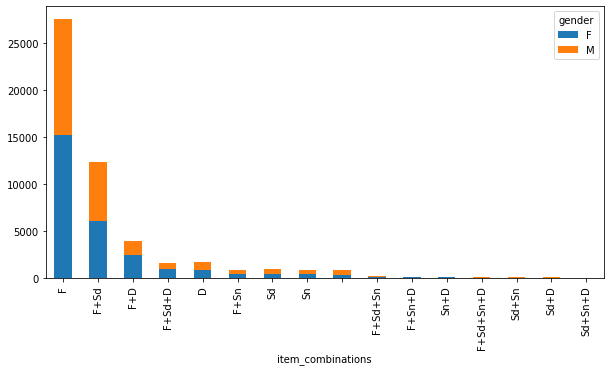

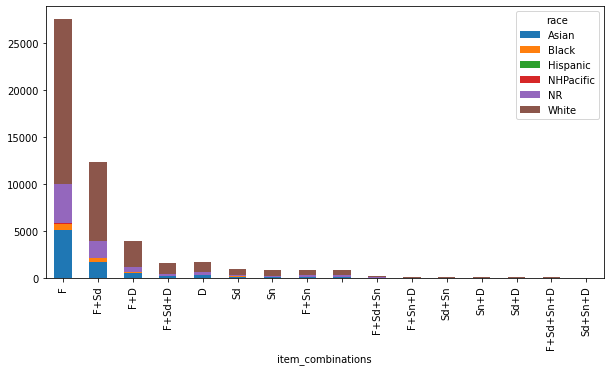

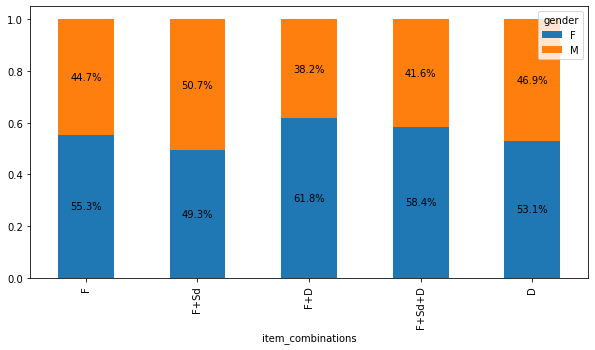

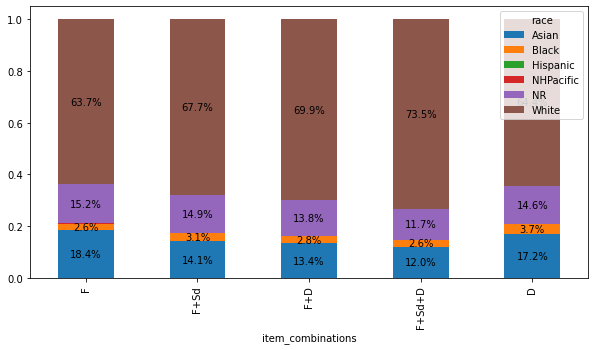

In [332]:
# gender/race percentage in different item combinations
analysis('item_combinations', ['gender','race'], 'Stacked', cleaned)
analysis('item_combinations', ['gender','race'], '100', cleaned)

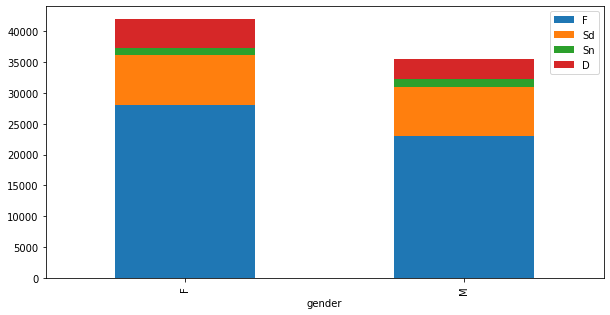

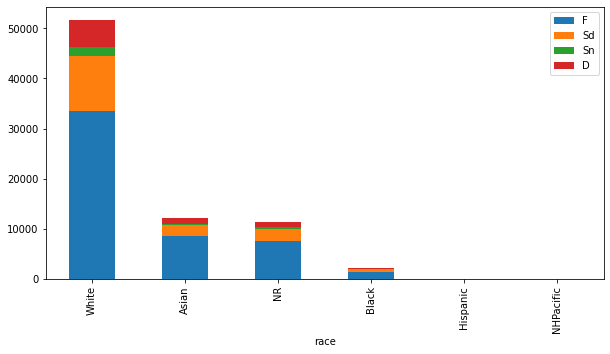

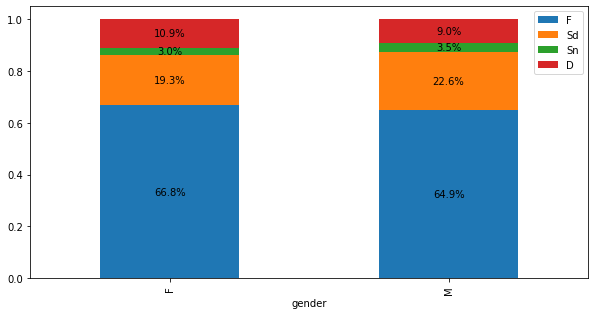

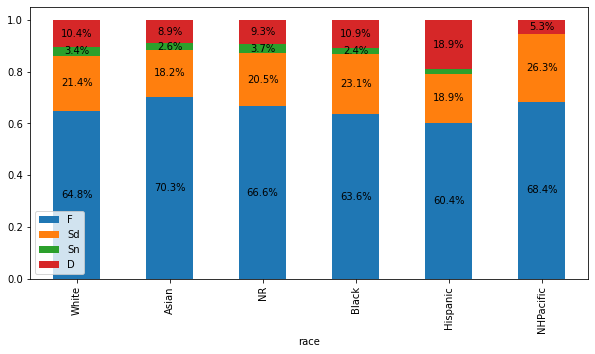

In [333]:
# item percentage in different gender/race
analysis(['F','Sd','Sn','D'], ['gender','race'], 'Stacked', cleaned)
analysis(['F','Sd','Sn','D'], ['gender','race'], '100', cleaned)